<a href="https://colab.research.google.com/github/khairul746/IDCamp-ML-Engineer-2024-Projects/blob/main/Analisis-Sentimen/Sentiment_Analysis_on_MyTelkomsel_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen pada Aplikasi My Telkomsel

## 1. Import Library dan Import Data

In [1]:
!pip install sastrawi

In [2]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
import unicodedata # Modul untuk bekerja dengan Unicode
import requests # Modul yang memungkinkan untuk mengirim htttp request
import os # Modul untuk pekerja terkait os seperti manajemen file

from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

from Sastrawi.Stemmer import StemmerFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
nltk.download('punkt_tab') # Download the punkt_tab data package
pd.options.mode.copy_on_write = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop, AdamW, Adam
from sklearn.model_selection import train_test_split

In [4]:
app_reviews_df = pd.read_csv('app_reviews.csv')

## 2. Dataset Overview

In [5]:
app_reviews_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a168778f-c1bd-4200-9d96-7ceff8722e32,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi sekarang terlalu berat dan susah di b...,3,25,3.43.40,2025-02-02 07:32:42,"Hai kak, maaf banget ya udah buat ga nyaman. T...",2025-02-02 08:12:24,3.43.40
1,db35c78a-a0a5-4967-9486-ac8ad792f755,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Termasuk apk online shop favorit ku, bisa dapa...",4,95,3.43.40,2025-02-01 21:29:36,"hi kak, makasih buat reviewnya, kalau kakak pu...",2025-02-01 22:19:21,3.43.40
2,a7349d33-365a-4d57-a496-af51e619a382,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Saya rubah reviewnya,ternyata selama ini cuma ...",1,10,3.43.40,2025-02-02 12:30:58,Hai kak maaf udh bikin ga nyaman terkait kenda...,2025-02-02 14:07:31,3.43.40


In [6]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               12000 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  11983 non-null  object
 7   at                    12000 non-null  object
 8   replyContent          11120 non-null  object
 9   repliedAt             11120 non-null  object
 10  appVersion            11983 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


In [7]:
df = app_reviews_df[['content','score']]

In [8]:
# Mengecek data yang kosong atau hilang
df.isnull().sum()

,0
content,0
score,0


In [9]:
# Menghapus baris yang memiliki duplikat
df.drop_duplicates(inplace=True)

## 3. Text Preprocessing

In [10]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def remove_superscripts_and_subscripts(text):
    # memfilter karakter yang bukan superscript atau subscript
    def is_not_super_or_sub(char):
        # Cek kategori Unicode karakter
        return not (unicodedata.name(char, "").startswith("SUPERSCRIPT") or
                    unicodedata.name(char, "").startswith("SUBSCRIPT"))

    # Filter karakter dari teks
    text = ''.join(filter(is_not_super_or_sub, text))
    return text

def casefoldingText(text):
    # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text):
    # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text):
    # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata

    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [11]:
# URL file slang words
url = "https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt"

# Mengambil konten file dari URL
response = requests.get(url)
if response.status_code == 200:
    content = response.text
    # Memproses konten ke dalam dictionary
    slangwords = {}
    for line in content.strip().split(","):
        if ":" in line:
            key, value = line.split(":", 1)  # Memisahkan kata slang dan arti
            key = key.strip('{"}') # Menghilangkan tanda kurung kurawal pada key
            value = value.strip('{"}') # Menghilangkan tanda kurung kurawal pada value
            slangwords[key.strip(' "\'')] = value.strip(' "\'') # Menyimpan pasangan key-value pada dictionary slangwords
else:
    print(f"Gagal mengunduh file dari URL. Status code: {response.status_code}")


In [12]:
list(slangwords.items())[:5]

[('@', 'di'),
 ('abis', 'habis'),
 ('ad', 'ada'),
 ('adlh', 'adalah'),
 ('afaik', 'as far as i know')]

In [13]:
def fix_slangwords(text):
    # Memperbaiki kata-kata slang dalam teks
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [14]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText).apply(remove_superscripts_and_subscripts)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [15]:
df.head()

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Aplikasi sekarang terlalu berat dan susah di b...,3,Aplikasi sekarang terlalu berat dan susah di b...,aplikasi sekarang terlalu berat dan susah di b...,aplikasi sekarang terlalu berat dan susah di b...,"[aplikasi, sekarang, terlalu, berat, dan, susa...","[aplikasi, berat, susah, buka, iklan, seliap, ...",aplikasi berat susah buka iklan seliap aplikas...
1,"Termasuk apk online shop favorit ku, bisa dapa...",4,Termasuk apk online shop favorit ku bisa dapat...,termasuk apk online shop favorit ku bisa dapat...,termasuk apk online shop favorit ku bisa dapat...,"[termasuk, apk, online, shop, favorit, ku, bis...","[apk, online, shop, favorit, voucherdiskon, mu...",apk online shop favorit voucherdiskon mudah fi...
2,"Saya rubah reviewnya,ternyata selama ini cuma ...",1,Saya rubah reviewnyaternyata selama ini cuma d...,saya rubah reviewnyaternyata selama ini cuma d...,saya rubah reviewnyaternyata selama ini cuma d...,"[saya, rubah, reviewnyaternyata, selama, ini, ...","[rubah, reviewnyaternyata, dibohongiditambahin...",rubah reviewnyaternyata dibohongiditambahin li...
3,"Maaf kak, sy mau mt solusi bagaimana cara baya...",5,Maaf kak sy mau mt solusi bagaimana cara bayar...,maaf kak sy mau mt solusi bagaimana cara bayar...,maaf kak saya mau makan teman solusi bagaimana...,"[maaf, kak, saya, mau, makan, teman, solusi, b...","[maaf, kak, makan, teman, solusi, bayar, spinj...",maaf kak makan teman solusi bayar spinjam coba...
4,"Tempat enak dan nyaman untuk berbelanja, paket...",4,Tempat enak dan nyaman untuk berbelanja paket ...,tempat enak dan nyaman untuk berbelanja paket ...,tempat enak dan nyaman untuk berbelanja paket ...,"[tempat, enak, dan, nyaman, untuk, berbelanja,...","[enak, nyaman, berbelanja, paket, cepat, ketuj...",enak nyaman berbelanja paket cepat ketujuan di...


## 4. Labeling Kata

In [16]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = "mdhugol/indonesia-bert-sentiment-classification"
# model = "indolem/indobert-base-uncased"

clf = AutoModelForSequenceClassification.from_pretrained(model)
tokenizer = AutoTokenizer.from_pretrained(model)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [17]:
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

pos_text = "Pelayanan shopee sangat ramah, sangat direkomendasikan berbelanja di aplikasi ini"
neg_text = "Aplikasi sering bermasalah, respon customer service juga kurang memuaskan"

result = sentiment_analysis(pos_text)
status = label_index[result[0]['label']]
score = result[0]['score']
print(f'Text: {pos_text} | Label : {status} ({score * 100:.3f}%)')

result = sentiment_analysis(neg_text)
status = label_index[result[0]['label']]
score = result[0]['score']
print(f'Text: {neg_text} | Label : {status} ({score * 100:.3f}%)')

Text: Pelayanan shopee sangat ramah, sangat direkomendasikan berbelanja di aplikasi ini | Label : positive (99.700%)
Text: Aplikasi sering bermasalah, respon customer service juga kurang memuaskan | Label : negative (99.399%)


In [18]:
def labeling(text):
    result = sentiment_analysis(text)
    return label_index[result[0]['label']]

In [19]:
from tqdm import tqdm
tqdm.pandas()

In [20]:
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
    if pd.isna(row.get("polarity")):  # Skip jika sudah ada nilai
        try:
            df.at[idx, "polarity"] = labeling(row["text_akhir"])
        except Exception as e:
            print(e)
            raise e

Processing Rows: 100%|██████████| 12000/12000 [02:01<00:00, 99.07it/s] 


In [21]:
df['polarity'].value_counts()

,count
polarity,
negative,5666
positive,3791
neutral,2543


## 5. Visualisasi Analisis Sentimen

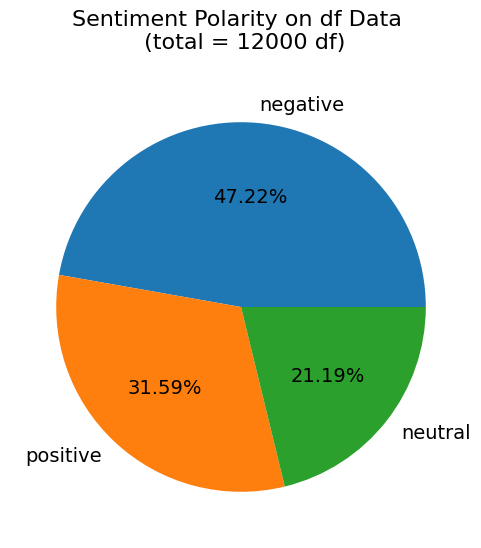

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.2f%%",
    textprops={"fontsize": 14},
)
ax.set_title(f"Sentiment Polarity on df Data \n (total = {len(df)} df)", fontsize=16, pad=20)
plt.show()

In [23]:
positive_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'positive']
negative_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'negative']

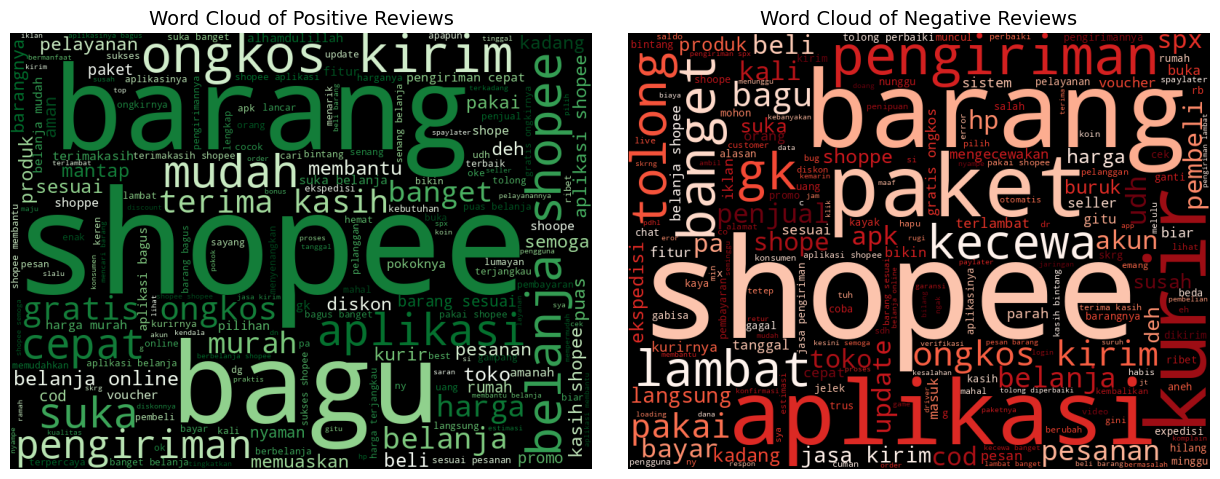

In [24]:
# Visualisasi Word Cloud
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Word Cloud pada review positif
list_postive_reviews = ""
for row_word in positive_reviews.iloc[:, 0]:
    list_postive_reviews += " " + (row_word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_postive_reviews)
ax[0].set_title(
    "Word Cloud of Positive Reviews",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

# Word Cloud pada review negatif
list_negative_reviews = ""
for row_word in negative_reviews.iloc[:, 0]:
    list_negative_reviews += " " + (row_word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_negative_reviews)
ax[1].set_title(
    "Word Cloud of Negative Reviews",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

## 6. Ekstraksi Fitur dan Membangun Model Klasifikasi

### 6.1 Embedding

In [25]:
def makeReviewDict(series):
    # Membuat dictionary berisi kata dan frekuensinya dari suatu pandas Series.
    corpus = []
    words = dict()
    for row in series:
        corpus.append(row)
        texts = row.split()
        for text in texts:
            if text not in words:
                words[text] = 1
            else:
                words[text] += 1
    return corpus, words, len(words)

In [26]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [27]:
corpus = makeReviewDict(df['text_akhir'])[0]
tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

In [28]:
# Melatih model Word2Vec
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=200, window=7, min_count=2, workers=4)

### 6.2 Train Test Split

In [29]:
# Fungsi untuk mendapatkan indeks kata
def get_vector(text, dim_size=200):
    vector_store = np.zeros([dim_size,dim_size])
    for idx, word in enumerate(text.split()):
        if word in w2v_model.wv:
            vector_store[:,idx] = w2v_model.wv[word]
    return vector_store

In [30]:
X = np.array(df['text_akhir'].apply(get_vector).tolist())

In [31]:
# Fungsi untuk mengubah baris dengan nilai boolean menjadi biner
def convert_to_binary(row):
    result = []
    for value in row.values:
        result.append(1 if value else 0)
    return result

In [32]:
y = np.array(pd.get_dummies(df['polarity']).apply(convert_to_binary, axis=1).tolist())

In [33]:
X.shape, y.shape

((12000, 200, 200), (12000, 3))

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Ubah X_train dari 3D ke 2D agar bisa di-resample
samples, timesteps, features = X.shape
X_reshaped = X.reshape(samples, timesteps * features)

# Lakukan oversampling dengan RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y)
X_resampled = X_resampled.reshape(-1, timesteps, features) # Kembalikan ke bentuk 3D

print("Original shape:", X.shape)
print("Resampled shape:", X_resampled.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### 6.3 Pelatihan Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(shape=(1,), initializer="zeros")

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=[-1, 0]) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(inputs * attention_weights, axis=1)

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('units', 64, 256, step=32), return_sequences=True)),
        Attention(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(hp.Int('dense_1', 64, 256, step=32), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(hp.Int('dense_2', 32, 128, step=32), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3)

tuner.search(X_resampled, y_resampled, epochs=10, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}, Best learning rate: {best_hps.get('learning_rate')}")


Trial 30 Complete [00h 01m 09s]
val_accuracy: 0.7311828136444092

Best val_accuracy So Far: 0.9808841347694397
Total elapsed time: 00h 19m 27s
Best units: 96, Best learning rate: 0.001


In [ ]:
# Bangun ulang model dengan hyperparameter terbaik
best_model = build_model(best_hps)

# Latih ulang model
history = best_model.fit(X_resampled, y_resampled,
                         epochs=40,  # Tambahkan lebih banyak epoch
                         batch_size=64,
                         validation_split=0.3)

Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.3896 - loss: 2.4328 - val_accuracy: 0.0000e+00 - val_loss: 2.0844
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5065 - loss: 1.6773 - val_accuracy: 0.0000e+00 - val_loss: 1.7751
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5157 - loss: 1.3087 - val_accuracy: 0.0000e+00 - val_loss: 1.5961
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5085 - loss: 1.1461 - val_accuracy: 0.0000e+00 - val_loss: 1.5430
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5270 - loss: 1.0620 - val_accuracy: 0.0000e+00 - val_loss: 1.4743
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5388 - loss: 1.0170 - val_accuracy: 0.0000e+00 - val_loss: 1.6014
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5532 - loss: 0.9824 - val_accuracy: 0.0056 - val_loss: 1.4040
Epoch 8/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5477 - loss: 0.9654 - 

In [ ]:
# Evaluasi model pada data uji
test_loss, test_acc = best_model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Loss: {test_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5852 - loss: 3.3650
Test Accuracy: 58.17 %
Test Loss: 3.4588


In [ ]:
# Plot Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper_left')
plt.show()

# Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()